#  NLP-lab :  Plongements de mots (word embeddings)

                                            Christopher Kermorvant

                            “The meaning of a word can be inferred by the company it keeps”

Dans cette série d'exercices, nous allons explorer  trois  plongements (embeddings) de mots :

*  [Collobert & Weston](http://www.jmlr.org/papers/volume12/collobert11a/collobert11a.pdf) https://ronan.collobert.com/senna/
* [GloVe](https://nlp.stanford.edu/projects/glove/)
* [BERT](https://huggingface.co/bert-base-uncased) 

   
Pour les deux premiers, nous examinerons les mots les plus proches et visualiserons leurs positions dans l'espaces après réduction de dimension. Puis nous procéderons à des [évaluations](https://arxiv.org/pdf/1801.09536.pdf) qualitatives et intrinsèques des embeddings.

Enfin nous étudierons les raisonnements par analogies que l'on peut conduire par l'arithmétique sur les embeddings (et leurs biais).

Pour BERT, nous étudierons la représentation d'un mot polysémique en fonction de son contexte.

Dans le code déjà fourni, ajouter votre code à l'endroit indiqué par `YOUR CODE HERE`.


In [1]:
# basic imports
import os

# disable warnings for libraries
import warnings
warnings.filterwarnings("ignore")

# configure logger
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)


## 1. Les fichiers d'embeddings pré-entraînés

Téléchargez dans `data` les fichiers contenant les embeddings :
* Collobert (taille 50) : [collobert_embeddings.txt.zip](https://storage.teklia.com/shared/deepnlp-labs/collobert_embeddings.txt.zip) qui contient les vecteurs d'embeddings  et [collobert_words.lst](https://storage.teklia.com/shared/deepnlp-labs/collobert_words.lst) qui contient les mots associés;
* Glove (taille 50):  [glove.6B.50d.txt.zip](https://storage.teklia.com/shared/deepnlp-labs/glove.6B.50d.txt.zip) qui contient à la fois les vecteurs et les mots.

Il faut décompresser les fichiers pour pouvoir les charger.

N'hésitez pas à ouvrir les fichiers pour voir ce qu'ils contiennent (c'est parfois surprennant).

#### Question : 
>* Donner la taille des fichiers d'embeddings avant unzip
>* En explorant le contenu des fichiers d'embedding, donner le nombre de mots pour lesquels ces fichiers fournissent des embeddings


avant le unzip la taille des fichiers est de 67 618 Ko pour glove
et de 24 275 Ko pour collobert

In [2]:
def nombre_mots_embedding(fichier):
    with open(fichier,"r",encoding="utf-8") as f:
        nombre_mots = sum(1 for ligne in f)
    return nombre_mots
    
nombre_mots_embedding("collobert_embeddings.txt")

130000

## 2. Exploration des embeddings

### Liste des mots les plus proches

L'objectif de cet exercice est de lister les mots les plus proches d'un mot donné pour l'embeddings Collobert. Dans un premier temps, nous allons charger les vecteurs de l'embedding Collobert dans un array numpy et les mots associés dans une liste python. Ensuite, nous utiliserons la structure de données [KDTree de scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html) pour faire une recherche rapide des vecteurs les plus proches d'une série de mots.

### Chargement des embeddings

#### Question : 
>* charger les vecteurs d'embeddings à partir du fichier `data/collobert_embeddings.txt` en utilisant la fonction numpy [genfromtxt](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html)
>* charger dans une liste python les mots associés aux vecteurs à partir du fichier `data/collobert_words.lst` (avec `open()` et `readlines()`)
>* vérifiez que les tailles sont correctes



In [3]:
import numpy as np
# YOUR CODE HERE
embedding = np.genfromtxt('collobert_embeddings.txt')

with open("collobert_words.lst", 'r', encoding='utf-8') as collobert_words:
    collobert_words = [line.strip() for line in collobert_words.readlines()]

print(len(collobert_words))
print(embedding.shape[0])

130000
130000


Les arbres KD (KD tree) sont une structure de données très efficace pour stocker de grands ensemble de points dans une espace multi-dimensionnel et faire des recherches très efficaces de plus proches voisins. 

#### Question 
> * Initialisez la structure de [KDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html) avec les vecteurs d'embeddings de Collobert
> * En utilisant la fonction [tree.query](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html#scipy.spatial.KDTree.query), afficher les 5 mots les plus proches des mots suivants : 'mother', 'computer', 'dentist', 'war', 'president', 'secretary', 'nurse' 
     * *Indice : vous pouvez utiliser la fonction `collobert_words.index(w)` pour obtenir l'indice d'un mot dans la liste des mots*
> * Créer une liste `words_plus_neighbors` contenant les mots et tous leurs voisins (pour la question suivante)

In [4]:
from scipy import spatial
# YOUR CODE HERE
tree = spatial.KDTree(embedding)

def mot_proche(mot, k=5):
    if mot not in collobert_words:
        print("mot pas dedans")
    
    index = collobert_words.index(mot)
    vecteur = embedding[index]
    distances, indices = tree.query(vecteur, k=k+1)
    words_plus_neighbors = []
    words_plus_neighbors.append(mot)
    for i in range(1,k+1):
        print(f"{collobert_words[indices[i]]}")
        words_plus_neighbors.append(collobert_words[indices[i]])

    return words_plus_neighbors, indices

In [5]:
mot_proche("mother")
print("\n")
mot_proche("compute")
print("\n")
mot_proche("dentist")
print("\n")
mot_proche("war")
print("\n")
mot_proche("president")
print("\n")
mot_proche("secretary")
print("\n")
mot_proche("nurse")

daughter
wife
father
husband
son


calculate
decode
computes
encode
optimize


pharmacist
midwife
physician
housekeeper
veterinarian


revolution
death
court
independence
history


governor
chairman
mayor
secretary
senator


minister
treasurer
chairman
commissioner
undersecretary


physician
veterinarian
dentist
surgeon
midwife


(['nurse', 'physician', 'veterinarian', 'dentist', 'surgeon', 'midwife'],
 array([ 81489,  88257, 123430,  30873, 112584,  74121]))

### Visualisation avec T-SNE

Les embeddings sont des vecteurs de plusieurs centaines de dimensions. Il n'est donc pas possible de les visualiser dans leur espace d'origine. Il est par contre possible d'appliquer des algorithmes de réduction de dimension pour les visualiser en 2 ou 3 dimension. Un des algorithmes de réduction de dimension permettant une visualisation en 2D est [tSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). 

#### Question
> * créer un object `word_vectors` de type `np.array` à partir d'une liste contenant tous les embeddings des mots de la liste `words_plus_neighbors`
> * créer un objet tSNE à partir de la librairie `from sklearn.manifold import TSNE` avec les paramètres `random_state=0`, `n_iter=2000` et `perplexity=15.0` pour une visualisation en 2 dimensions
> * Calculer *T* la transformation tSNE des vecteur `word_vectors` en appliquant la function `.fit_transform(word_vectors)` à l'objet tSNE. Cette fonction estime les paramètres de la transformation tSNE et retourne la représentation en dimension réduite des vecteurs utilisés pour l'estimation.
> * Utiliser la fonction `scatterplot` de [seaborn](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) pour représenter les points en 2 dimensions  et ajouter les labels des mots avec la function `plt.annotate`.

daughter
wife
father
husband
son


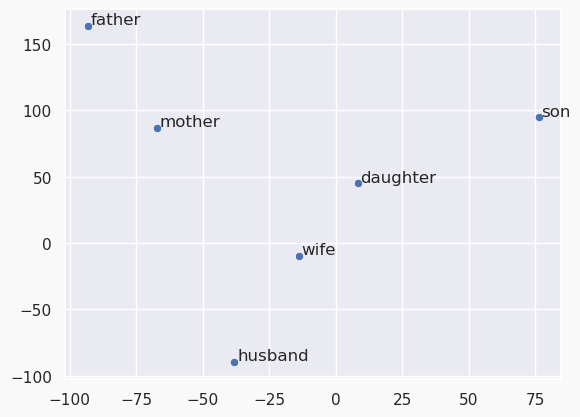

In [6]:
from sklearn.manifold import TSNE
# graphics
import matplotlib.pyplot as plt
# display matplotlib graphics in notebook
%matplotlib inline 
import seaborn as sns

# retrieve the word representation
# YOUR CODE HERE
words_plus_neighbors, indices = mot_proche("mother")
word_vectors = embedding[indices]
# create the tSNE transform
# YOUR CODE HERE
# fit and transform the word vectors, store in T
# YOUR CODE HERE
T= TSNE(random_state=0, n_iter=2000, perplexity = 2.0).fit_transform(word_vectors)

# plot
fig = plt.figure()
fig.patch.set_facecolor('#f9f9f9')

sns.set(rc={'figure.figsize':(14, 8)})
sns.set(font_scale=1)

sns.scatterplot(x=T[:, 0], y=T[:, 1])

for label, x, y in zip(words_plus_neighbors, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## 3. Evaluation des embeddings 

### Évaluation intrinsèque

[A Survey of Word Embeddings Evaluation Methods](https://arxiv.org/pdf/1801.09536.pdf), Bakarov, 2018.


>les distances entre les mots dans un espace vectoriel pourraient être évaluées à l'aide des jugements heuristiques humains sur les distances sémantiques réelles entre ces mots (par exemple, la distance entre tasse et gobelet définies dans un intervalle continu 0, 1 serait 0.8 puisque ces mots sont synonymes, mais pas vraiment la même chose).



### Téléchargement des datasets pré-établis et annotés manuellement

Nous allons utiliser 4 jeux de données  pour évaluer la qualité des embeddings : [MEN](http://clic.cimec.unitn.it/~elia.bruni/MEN.html), [WS353R](http://www.aclweb.org/anthology/N09-1003.pdf), [SimLex999](http://leviants.com/ira.leviant/MultilingualVSMdata.html) et [MTurk](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.205.8607&rep=rep1&type=pdf). 


Ces jeux de données contiennent des paires de mots dont la proximité sémantique a été évaluée manuellement par des humains. Pour chaque dataset, dataset.X contient une liste de paires de mots et dataset.y contient le score de proximité pour chaque paire.

* MEN, 3 000 paires évaluées par relation sémantique avec une échelle discrète de 0 à 50
* SimLex-999, 999 paires évaluées avec un fort respect pour la similarité sémantique avec une échelle de 0 à 10
* MTurk-287, 287 paires évaluées par relation sémantique avec une échelle de 0 à 5
* WordSim-353, 353 paires évaluées par similarité sémantique (cependant, certains chercheurs trouvent les instructions pour les évaluateurs ambiguës en ce qui concerne la similarité et l'association) sur une échelle de 0 à 10

In [7]:
# custom functions
import similarity

similarity_tasks = {
    "MEN": similarity.fetch_MEN(),
    "WS353R": similarity.fetch_WS353(which="relatedness"),
    "SimLex999": similarity.fetch_SimLex999(),
    "MTurk": similarity.fetch_MTurk(),
}

for name, dataset in similarity_tasks.items():
    print('\n', name, ':',len(dataset.X),'items')
    for data, score in zip(dataset.X[:4], dataset.y[:4]):
        print(' '*4, ', '.join(data), ':', score)


 MEN : 3000 items
     sun, sunlight : [10.]
     automobile, car : [10.]
     river, water : [9.8]
     stair, staircase : [9.8]

 WS353R : 252 items
     computer, keyboard : 7.62
     Jerusalem, Israel : 8.46
     planet, galaxy : 8.11
     canyon, landscape : 7.53

 SimLex999 : 999 items
     old, new : 1.58
     smart, intelligent : 9.2
     hard, difficult : 8.77
     happy, cheerful : 9.55

 MTurk : 287 items
     episcopal, russia : 5.5
     water, shortage : 5.428571428
     horse, wedding : 4.533333334
     plays, losses : 6.4


### Résultats évaluation intrinsèque

Notre objectif est de comparer les similarités entre les paires de mots des datasets calculées à partir des embeddings et celles données par les annotateurs humains. Si un embedding prédit les similarités de la même manière que les humains, on estime qu'il est bon. On peut donc calculer la corrélation entre la proximité donné par l'embedding et celle donnée par les humains pour chaque paire de mots du dataset.

Pour cet excercice, nous allons utiliser  le classe [Embeddings](https://polyglot.readthedocs.io/en/latest/polyglot.mapping.html#module-polyglot.mapping.embeddings) de polyglot. Pour charger un embeddind avec cette classe : 

`glove_embeddings =  Embedding.from_glove('data/glove.6B.50d.txt')`

Pour pouvoir charger les embeddings de Collobert de la même manière, il faut mettre les mots et les vecteurs dans un seul fichier, par exemple avec la commande linux `paste`:

`paste -d ' ' collobert_words.lst collobert_embeddings.txt > collobert.txt`



#### Question

> * pour chaque embedding Collober et Glove, et chaque dataset (MEN, WS353R, SimLex999 et MTurk), calculer la similarité entre les proximités données par l'embedding et celles données par les humains. On utilisera la fonction `similarity.evaluate_similarity(word_embeddings, dataset.X, dataset.y)` qui renvoit le [coefficient de correlation de Spearman](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_de_Spearman).
> * stocker les scores  pour chaque embedding et chaque dataset dans une liste `similarity_results = []` sous forme d'un dictonnaire : `similarity_results.append({'Embeddings': embeddings_name, 'Dataset': name, 'Score': score})`


In [ ]:
# embedding functions
from polyglot.mapping import Embedding

similarity_results = []
# Load both embeddings with Embedding.from_glove from Polyglot
# YOUR CODE HERE
glove_embeddings =  Embedding.from_glove('glove.6B.50d.txt')
with open("collobert_embeddings.txt", 'r', encoding='utf-8') as f:
    collobert_embeddings = [line.strip() for line in f.readlines()]


# Loop on embeddings
for embeddings_name, embeddings in [('collobert', collobert_embeddings), ('glove', glove_embeddings)]:
    # loop on tasks
    for name, dataset in similarity_tasks.items():
        # compute similarity
        # YOUR CODE HERE
        score = similarity.evaluate_similarity(word_embeddings, dataset.X, dataset.y)
        similarity_results.append({'Embeddings': embeddings_name, 'Dataset': name, 'Score': score})

AttributeError: 'str' object has no attribute 'vocabulary'

In [ ]:
similarity_results[:5]

### Visualisation des résultats de similarité

Le code suivant permet de visualiser les coefficients de corrélation pour chaque dataset sur les différents jeux de test.

#### Question
> * Quel est selon ces métriques le meilleur embedding ? 

In [ ]:
import pandas as pd


df = pd.DataFrame.from_dict(similarity_results, orient='columns')
df

fig = plt.figure()
fig.patch.set_facecolor('#f9f9f9')



sns.set(rc={'figure.figsize':(8, 6)})
sns.set(font_scale=1)

colors = ["#e74c3c", "#75d9fc", "#b4e0ef", "#34495e", "#e74c3c", "#2ecc71"]
ax = sns.barplot(x="Dataset", y="Score", hue="Embeddings", data=df, errwidth=0, palette=sns.color_palette(colors))


ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=3, fancybox=True, shadow=False)
ax.set(xlabel="", ylabel="")

plt.show()

## Évaluation d'analogies

Notre objectif est maintenant d'explorer les relations sémantiques induites par l'arithmétique sur les embeddings. Nous allons donc explorer les analogies induites par les embeddings sous forme de raisonnement du type : "l'homme est au roi ce que la femme est à ?", la réponse étant "la reine". On peut calculer la réponse avec les représentations fournies par l'embedding par :  

`v = vecteur(roi)-vecteur(homme)+vecteur(femme)`. 

La réponse étant alors le mot dont la représentation est la plus proche du vecteur `v`. Pour trouver le mot dont le vecteur est le plus proche de `v`, il faut définir une distance dans l'espace des embeddings. Nous utiliserons la [similarité cosinus](https://fr.wikipedia.org/wiki/Similarit%C3%A9_cosinus)

#### Question
>* Implémenter la similarity cosinus à l'aide des fonctions [np.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html#numpy.dot) et [np.linalg.norm](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm)
>* Appliquer le calcul d'analogies sur les triplets proposés ou ceux de votre choix. Observez-vous [ce phénomène](https://arxiv.org/pdf/1607.06520.pdf) ?

In [ ]:
def my_cosine_similarity(a,b):
    # YOUR CODE HERE

def sorted_by_similarity(word_embeddings, base_vector):
    """Returns words sorted by cosine distance to a given vector, most similar first"""
    words_with_distance = [(my_cosine_similarity(base_vector, word_embeddings[w]), w) 
                           for w in word_embeddings.vocabulary]

    return sorted(words_with_distance, key=lambda t: t[0], reverse=True)

def is_redundant(word):
    return (
        word_1.lower() in word.lower() or
        word_2.lower() in word.lower() or
        word_3.lower() in word.lower())


pairs = [(['man', 'woman'], 'king'), 
         (['man', 'programmer'], 'woman'), 
         (['father', 'doctor'], 'mother'),
         (['father', 'facebook'], 'mother')
        ]

words_and_responses = []

# Note : you may need to update the following line with your Polyglot Embeddings
for embeddings_name, embeddings in [('collobert', collobert_embeddings), ('glove', glove_embeddings)]:
    for pair in pairs:
        word_1, word_2, word_3 = pair[0][0], pair[0][1], pair[1]
        
        closest = sorted_by_similarity(embeddings, 
                                       embeddings[word_2] - embeddings[word_1] + 
                                       embeddings[word_3])[:10]

        closest = [(dist, w) for (dist, w) in closest if not is_redundant(w)] #
        
        print("{} + {} - {} = ? {}".format(word_2, word_3, word_1, closest[0][1]))
        words_and_responses += [word_1, word_2, word_3,closest[0][1]]

### Visualisation des analogies

Les relations d'analogies peuvent se visualiser dans l'espace des embeddings après réduction de dimension, par exemple avec tSNE.

In [ ]:
# Note : you may need to update the following line with your Polyglot Embeddings
for embeddings_name, embeddings in [('collobert', collobert_embeddings), ('glove', glove_embeddings)]:
    
    word_vectors = np.array([embeddings[word] for word in words_and_responses[:4]])
    
    tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=3.0)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(word_vectors)
    
    fig = plt.figure()
    fig.patch.set_facecolor('#f9f9f9')

    sns.set(rc={'figure.figsize':(6, 6)})
    sns.set(font_scale=1.3)

    sns.scatterplot(x=T[:, 0], y=T[:, 1])
    
    for label, x, y in zip(words_and_responses, T[:, 0], T[:, 1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Evaluation des embeddings de BERT

BERT a été un des premiers modèles de langue Transformer, entraînés sur de gros corpus, disponible librement. De nombreux modèles sont disponibles sur HuggingFace.

Comme BERT est un modèle contextuel, il est nécessaire de lui faire prédire des phrases entières pour étudier les embeddings de mots qu'il produit. Dans cette section, nous allons comparer les embeddings obtenus pour des mots polysémiques en fonction de la phrase dans laquelle ils sont utilisés.

En anglais, *plant* possède deux sens : celui d'usine et celui d'un végétal. Avec un embedding non contextuel, de type Glove ou Colobert, ces deux sens du mot plus sont associés à un identique embedding. Avec BERT, nous allons voir que le même mot peut avoir plusieurs embeddings en fonction du contexte.

First, load the BERT model and tokenizer from HuggingFace : 

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load pre-trained model 
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # to access the hidden states
                                  )
# set the model to "evaluation" mode
model.eval()

### Tokenizer

Les modèles de langues sont entrainés avec un découpe spécifique des phrases en token. Ces tokens peuvent être des mots ou des parties de mots. Il est nécessaire d'utiliser le tokenizer correspondant à chaque model.

tokenizer.vocab.keys() donne la liste de tous les tokens connus du modèle de langue. 

#### Question
>* combien de token différents sont connu du tokenizer de BERT ?
>* affichez une centaine de token aléatoirement. Que constatez-vous ?

In [ ]:
import random
# number of token in tokenizer
# YOU CODE HERE
# sample of 100 tokens
# YOU CODE HERE


Le tokenizer découpe les phrases et transforme les éléments (mots ou sous-mots) en indice. 

BERT peut traiter plusieurs phrases mais il faut lui indiquer le découpage en phrases (segment) avec un indice : 0 pour la première phrases, 1 pour la deuxième. 

Deux tokens spécifiques doivent être aussi ajoutés : 
* [CLS], un token spécifique utilisé pour la classification de phrase
* [SEP], le token de fin de phrase.

#### Question
>* Appliquer la fonction bert_tokenize sur les 3 phases et conservez les 3 vecteurs (index, token, segment)
>* Affichez ces informations pour chacune des phrases et vérifier que le mot *plant* a bien le même indice de token dans les deux phrases où il apparait.

In [ ]:
snt1 = "The plant has reached its maximal level of production."
snt2 = "The cars are assembled inside the factory."
snt3 = "A plant needs sunlight and water to grow well."


def bert_tokenize(snt):
    """ Apply the BERT tokenizer to a list of words representing a sentence
        and return 3 lists: 
        - list of token indx
        - list of token for debugging, not used by the BERT model
        - list of sentence index
        """
    # Add the special tokens.
    tagged_snt = "[CLS] " + snt + " [SEP]" 
    # Tokenize
    tokenized_snt = tokenizer.tokenize(tagged_snt)
    # convert tokens to indices
    indexed_snt = tokenizer.convert_tokens_to_ids(tokenized_snt)
    # mark the words in sentence.
    segments_ids = [1] * len(tokenized_snt)

    return (indexed_snt, tokenized_snt, segments_ids)

# YOUR CODE HERE



## Inférence

Pour calculer les embeddings, il est nécessaire de faire une prédiction avec le modèle BERT sur une phrase complète. La fonction *predict_hidden* convertit les listes d'indices de token et de segment en tenseur pytorch et applique le modèle. 

Le modème utilisé est un modèle à 12 couches. Nous allons utiliser la dernière couche caché du modèle comme embedding pour représenter les mots. D'autres solutions serait possible, comme une concaténation ou une moyene de plusieurs couches.


#### Question
>* Appliquer le modèle à chacune des 3 phrases et stocker les embeddings obtenus (tenseurs)
>* Afficher la dimension des tenseurs obtenus. Quelle est la dimension du vecteur d'embedding pour chaque mot ?


In [ ]:

def predict_hidden(indexed_snt, segments_ids):
    """Apply the BERT model to the input token indices and segment indices
        and return the last hidden layer
    """
    with torch.no_grad():
        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([indexed_snt])
        segments_tensors = torch.tensor([segments_ids])
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]
        one_hidden_layer = hidden_states[12][0]
        
    return one_hidden_layer

# YOUR CODE HERE



La couche cachée renvoyée par la fonction *predict_hidden* est un tenseur contenant pour chaque token de la phrase d'entrée un vecteur contextuel le représentant. On peut utiliser ce vecteur pour représenter le sens de ce mot en fonction de son contexte. Nous allons comparer la représentation du mot polysémique *plant* en fonction de son contexte.

#### Question
>* En utilisant la [distance cosinus](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html), calculer les distances suivantes:
>   * distance entre *plant* dans la phrase 1 (plant-factory) et *plant* dans la phrase 3 (plant-vegetal)
>   * distance entre *plant* dans la phrase 1 (plant-factory) et *factory* dans la phrase 2 
>   * distance entre *plant* dans la phrase 1 (plant-factory) et *production* dans la phrase 2 
>   * distance entre *plant* dans la phrase 3 (plant-vegetal) et *production* dans la phrase 2 
> * Comment interprêter ces distances ?

In [ ]:
from scipy.spatial.distance import cosine

# YOUR CODE HERE
